# Run the Python version of SOLID

Import libraries.

In [1]:
from MDN.benchmarks.tss.SOLID.model import model as SOLID
from MDN import get_tile_data, image_estimates
 
import matplotlib.pyplot as plt
import numpy as np 
import os

In [2]:
import sys
sys.argv=['']
del sys

Setup parameters for SOLID.

In [ ]:
path   =  './assets/S2A_MSI_2018_12_27_16_02_16_T18SUJ_L2W.nc'
sensor = 'MSI'

     # Extract relevant wavelengths and respective Rrs from the netcdf
wavelengths, Rrs = get_tile_data(path, sensor, allow_neg=False) 
print(f'Wavelengths: {wavelengths}  Rrs shape: {Rrs.shape}')

    # Apply SOLID to the extracted Rrs
MDN_kwargs = {
   'verbose'    : True,  # Whether to shown progress through bagging rounds
   'use_gpu'    : False, # Whether to run predictions on /gpu:0, if available.
   'chunk_size' : None,  # Number of samples the model is applied to at one time. None indicates full set is estimated at once.
}

Run SOLID and plot predictions.

In [ ]:
tss = image_estimates(Rrs, function=SOLID, wavelengths=wavelengths, sensor=sensor, **MDN_kwargs)
print(f'TSS shape: {tss.shape}')
 
plt.imshow(np.squeeze(tss), vmin=0, vmax=100)
plt.colorbar()
plt.title('2018-12-27 : MSI @ 60m')
plt.gca().tick_params(labelcolor='none', bottom=False, left=False)
#plt.savefig('SOLID_20181227.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

# Prepare input file for Earth Engine

Netcdf file has to be converted to geotiff before it can be uploaded to Earth Engine. We use gdal to convert it.




In [7]:
from osgeo import gdal, osr, gdal_array
import numpy as np
import pandas as pd

Inspect netcdf file

In [ ]:
ds = gdal.Open(path)
for item in ds.GetSubDatasets():
    print(item[0])
    index = item[0].rfind(':') + 1
    print(item[0][index:])

Find geo transform by reading lon and lat values from netcdf file.

In [9]:
subset = gdal.Open('NETCDF:"' + path + '":lon')

print(f'shape: {subset.ReadAsArray().shape}')
print(f'rasterXSize: {subset.RasterXSize}')
print(f'rasterYSize: {subset.RasterYSize}')

lngmin  = subset.ReadAsArray()[0,0]
lngmax = subset.ReadAsArray()[subset.RasterYSize - 1, subset.RasterXSize - 1]
print(f'longitude min: {lngmin}')
print(f'longitude max: {lngmax}')

subset = gdal.Open('NETCDF:"' + path + '":lat')
latmin  = subset.ReadAsArray()[0,0]
latmax = subset.ReadAsArray()[subset.RasterYSize - 1, subset.RasterXSize - 1]
print(f'latitude min: {latmin}')
print(f'latitude max: {latmax}')

transform = (lngmin, (lngmax - lngmin) / subset.RasterXSize, 0.0, latmin, 0.0, (latmax - latmin) / subset.RasterYSize)
print(f'geo transform: {transform}')


shape: (1069, 805)
rasterXSize: 805
rasterYSize: 1069
longitude min: -76.60002136230469
longitude max: -76.05133056640625
latitude min: 39.04213333129883
latitude max: 39.625762939453125
geo transform: (-76.60002, 0.0006816034731657608, 0.0, 39.042133, 0.0, 0.0005459584734839073)


Define method for converting to geotiff.

In [10]:
import os

def create_geotiff(suffix, input_file, result, geot):
    # Get subdatasets 
    ds = gdal.Open(input_file)
    subsets = ds.GetSubDatasets()

    # Read the first one 
    sub_ds = gdal.Open(subsets[0][0])
    xsize = sub_ds.RasterXSize
    ysize = sub_ds.RasterYSize
    data = sub_ds.ReadAsArray(0, 0, xsize, ysize)
    dt = gdal_array.NumericTypeCodeToGDALTypeCode(data.dtype)
    if type(dt) != np.int:
        if dt.startswith('gdal.GDT_') is False:
            dt = eval('gdal.GDT_'+dt)
    new_fname = suffix + '.tif'
    
    # Define projection
    proj = osr.SpatialReference()
    proj.SetWellKnownGeogCS('WGS84')

    driver = gdal.GetDriverByName('GTiff')
    zsize = len(subsets) + 1
    ds = driver.Create(new_fname, xsize, ysize, zsize, dt)
    ds.SetProjection(proj.ExportToWkt())
    ds.SetGeoTransform(geot)

    for index in range(0, len(subsets) - 1):
      subset = gdal.Open(subsets[index][0])
      data = subset.ReadAsArray(0, 0, xsize, ysize)
      ndv = subset.GetRasterBand(1).GetNoDataValue()
      d = data
#      d = np.flip(data, 0)
      d[np.isnan(d)] = ndv
      ds.GetRasterBand(index + 1).WriteArray(d)
      ds.GetRasterBand(index + 1).SetNoDataValue(ndv)
      print(f'(Writing band: {subsets[index][0]}')

    d = np.flip(result, 0)
    subset = gdal.Open(subsets[2][0])
    d[np.isnan(d)] = subset.GetRasterBand(1).GetNoDataValue()
    ds.GetRasterBand(len(subsets) + 1 ).WriteArray(d)
    ds.GetRasterBand(len(subsets) + 1).SetNoDataValue(ndv)
    print(f'(Writing band tss')

    ds.FlushCache()
    return new_fname

Convert prediction result to geotiff and write it to google drive.




In [ ]:
#subset = gdal.Open('NETCDF:"/content/drive/MyDrive/S2A_MSI_2018_12_27_16_02_16_T18SUJ_L2W.nc":Rrs_443')
#ndv, xs, ys, geot, proj = get_netcdf_info(path, 'Rrs_443')

outdir = './'
outname = 'geotiff'
#create_geotiff('{}{}out_{}'.format(outdir, os.path.sep, outname), subset.ReadAsArray()[0:1069, 0: 805], ndv, xs, ys, transform, proj)
#create_geotiff('{}{}out_{}'.format(outdir, os.path.sep, outname), tss[:,:,0], ndv, xs, ys, transform)#
create_geotiff('{}{}out_{}'.format(outdir, os.path.sep, outname), path, tss[:,:,0], transform)

File has to be uploaded to Google bucket first before uploading it to Earth Engine. Login to Google Cloud.

In [12]:
from google.cloud import storage
def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket."""

    storage_client = storage.Client()

    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    print(
        "File {} uploaded to {}.".format(
            source_file_name, destination_blob_name
        )
    )


Upload file to bucket.

In [ ]:
BUCKET_NAME = os.environ.get('BUCKET')
upload_blob(BUCKET_NAME, 'out_geotiff.tif', 'solid.tif')

Check files in bucket

In [ ]:
from google.cloud import storage
BUCKET_NAME = os.environ.get('BUCKET')
storage_client = storage.Client()
blobs = storage_client.list_blobs(BUCKET_NAME)
print("Files:")
for blob in blobs:
    print(blob.name)

Sign in to Earth Engine.

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()

Upload file to Earth Engine from Google Cloud Storage. Change the ASSET_ID to your asset id.

In [ ]:
import json
ASSET_ID = os.environ.get('EE_ASSET_ID')
GS_URL = 'gs://' + BUCKET_NAME + '/solid.tif'
manifest = {
  "name": "projects/earthengine-legacy/assets/" + ASSET_ID,
  "tilesets": [
    {
      "sources": [
        {
          "uris": [
            GS_URL
          ]
        }
      ]
    }
  ]
}
ds = gdal.Open(path)
bands = []
ind = 0
print("Writing bands:")
for item in ds.GetSubDatasets():
    index = item[0].rfind(':') + 1
    band = item[0][index:]
    print(band)
    bands.append({"id": band, "tileset_band_index": ind})
    ind += 1

bands.append({"id": "tss", "tileset_band_index": ind})
print("tss")
manifest["bands"] = bands
MANIFEST_FILE = outdir + "/maifest.json"
f = open(MANIFEST_FILE, "w")
f.write(json.dumps(manifest))
f.close()

!earthengine upload image --manifest {MANIFEST_FILE}

Check upload job.

In [ ]:
ee.batch.Task.list()[0]

Now that results are available in Earth Engine show it on map.


In [ ]:
import folium
ASSET_ID = os.environ.get('EE_ASSET_ID')

image = ee.Image(ASSET_ID)
vis = {
  'bands': ['tss'],
  'min': 0,
  'max': 100,
  'palette': ['081d58','253494','225ea8','1d91c0','41b6c4','7fcdbb','c7e9b4','edf8b1','ffffd9']
}
map_id = image.getMapId(vis)
map = folium.Map(location=[39.279839, -76.31669])
folium.TileLayer(
  tiles=map_id['tile_fetcher'].url_format,
  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
  overlay=True,
  name='Prediction for TSS',
).add_to(map)

display(map)

# Use Earth Engine asset as input to calculation
Now, that we have imported the input image to EE, let's try to use the Earth Engine image itself to do the calculation. We convert each band to a numpy array and stack them to a 3 dim tensor. 
Since 'sampleRectangle' works only for small rectangles, the selected rectangle is subdivided and the parts are stacked together. 

In [7]:
def convert_image(image, band_names, lng_min, lng_max, lat_min, lat_max, delta):

    masked_image = image.unmask(0, False)

    x_nums = np.linspace(lng_min, lng_max, int((lng_max - lng_min) / delta))
    y_nums = np.linspace(lat_min, lat_max, int((lat_max - lat_min) / delta))
    
    array = []

    for x in x_nums:
        print(x)
        y_array = []
        for y in y_nums:
            geometry = ee.Geometry.Polygon([[[x,y],[x, y + delta],
                            [ x + delta, y + delta], [ x + delta, y],
                            [ x, y]]])
            values = masked_image.sampleRectangle(region=geometry).getInfo().get('properties')
            for index in range(len(band_names)):
                band_name = band_names[index]
                arr = values.get(band_name)
                np_arr = np.array(arr)
                if len(y_array) <= index:                
                    y_array.append(np_arr)
                else:
                    if y_array[index].shape != np_arr.shape: 
                        np_arr.resize((np_arr.shape[0], y_array[index].shape[1]))
                    y_array[index] = np.vstack((y_array[index], np_arr))

        for index in range(len(band_names)):
            if len(array) <= index:                
                array.append(y_array[index])
            else:
                if array[index].shape != y_array[index].shape: 
                    y_array[index].resize((array[index].shape[0], y_array[index].shape[1]))
                array[index] = np.hstack((array[index], y_array[index]))
                
    np_array = np.stack(array, axis=2)
    np_array = np.flip(np_array, axis=0)
    return np_array

In [ ]:
lng_min = -76.60002136230469
lng_max = -76.05133056640625
lat_min = 39.04213333129883
lat_max = 39.625762939453125

delta = 0.05

band_names = ['Rrs_443', 'Rrs_492', 'Rrs_560', 'Rrs_665', 'Rrs_704', 'Rrs_740', 'Rrs_783']

np_array = convert_image(image, band_names, lng_min, lng_max, lat_min, lat_max, delta)
np_array.shape

In [ ]:
bands = [443, 492, 560, 665, 704, 740, 783] 
tss = image_estimates(np_array, function=SOLID, wavelengths=bands, sensor=sensor, **MDN_kwargs)

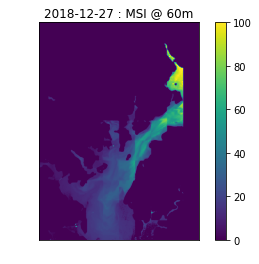

In [10]:
plt.imshow(np.squeeze(tss), vmin=0, vmax=100)
plt.colorbar()
plt.title('2018-12-27 : MSI @ 60m')
plt.gca().tick_params(labelcolor='none', bottom=False, left=False)
plt.show()

# Run SOLID on a sentinel image from EE
Let's try the calculation on an sentinel image from EE, the bands are B1 to B7. We choos an image which covers the selected geometry. 

In [ ]:
geometry = ee.Geometry.Polygon([[[lng_min,lat_min],[lng_min,lat_max],
                                [lng_max, lat_max], [lng_max, lat_min],
                                [lng_min, lat_min]]])
band_names = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7'] 

area=geometry
#Time window
startyear = 2020
endyear = 2020;
startmonth = 1
endmonth = 12

imageCollection = ee.ImageCollection("COPERNICUS/S2_SR")\
  .filterBounds(area)\
  .filter(ee.Filter.lt('HIGH_PROBA_CLOUDS_PERCENTAGE',50))\
  .filter(ee.Filter.calendarRange(startyear,endyear,'year'))\
  .filter(ee.Filter.calendarRange(startmonth,endmonth,'month'))\
  .sort('system:time_start')\
  .set('SENSOR_ID', 'OLI_TIRS')

#old s2 cloudmask and water, there is a different new one, but keeping it simple
def cloudmask(img):
                  mask = img.select(['SCL']).eq(6)
                  notcloud=img.select(['QA60']).eq(0)
                  img=img.updateMask(mask)
                  img=img.updateMask(notcloud)
                  return img

imageCollection = imageCollection.map(cloudmask)
#sentinel_image = ee.Image(imageCollection.mean())
sentinel_image = ee.Image(imageCollection.sort('HIGH_PROBA_CLOUDS_PERCENTAGE').first());
vis = {"bands":["B4","B3","B2"],"min":0,"max": 800,"gamma":1}

map_id = imageCollection.mean().getMapId(vis)
map = folium.Map(location=[39.279839, -76.31669])
folium.TileLayer(
  tiles=map_id['tile_fetcher'].url_format,
  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
  overlay=True,
  name='Sentinel',
).add_to(map)
folium.GeoJson(
    data = geometry.getInfo(),
    name = 'Geometry',
    overlay = True,
    control = True
).add_to(map)

display(map)

In [56]:
# Reduce all bands to the same resolution
sentinel_b1 = sentinel_image.select('B1')
proj_b1 = sentinel_b1.projection()
for band in band_names:
    reduced_image = sentinel_image.select(band).reduceResolution(reducer=ee.Reducer.mean(),maxPixels=1024).reproject(crs=proj_b1)    
    sentinel_image = ee.Image(sentinel_image).addBands(reduced_image, ee.List([band]), True)

In [ ]:
np_array = convert_image(sentinel_image, band_names, lng_min, lng_max, lat_min, lat_max, delta)
np_array.shape

In [ ]:
# Run the calculation
tss = image_estimates(np_array, function=SOLID, wavelengths=bands, sensor=sensor, **MDN_kwargs)